In [8]:
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from glob import glob


use_cuda = torch.cuda.is_available()

In [9]:
class DSet(Dataset):

    def __init__(self, samples, step=100):
        self.data = np.zeros((len(samples), step), dtype=np.float32)
        self.target = np.zeros(len(samples), dtype=np.float32)
        raw_data = np.load('data/prop_span.npz')
        for i, sample in enumerate(samples):
            span = raw_data[sample]
            volumn = np.log10(span + 1) / 8.1 * step
            for item in volumn.astype(int):
                self.data[i][item] += 1
            if 'rumor' in sample:
                self.target[i] = 1

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return torch.from_numpy(self.data[idx]), self.target[idx]


In [10]:
class CNN(nn.Module):

    def __init__(self, input_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 8, 3, padding=1)
        self.conv2 = nn.Conv1d(8, 16, 3, padding=1)
        self.fc1 = nn.Linear(input_size // 4 * 16, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = x.view(x.size(0), 1, -1)
        x = F.relu(F.max_pool1d(self.conv1(x), 2))
        x = F.relu(F.max_pool1d(self.conv2(x), 2))
        x = F.dropout(x.view(x.size(0), -1), training=self.training)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.sigmoid(x)

In [11]:
class RNN(nn.Module):

    def __init__(self, input_size, hidden_size=64, bidirectional=True):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_directions = 2 if bidirectional else 1
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_size * self.n_directions, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1, self.input_size)
        h0 = self._init_hidden_state(x.size(0))
        x, hn = self.rnn(x, h0)
        x = self.fc(x[:, -1, :])
        return F.sigmoid(x)

    def _init_hidden_state(self, batch_size):
        h0 = torch.zeros(self.n_directions, batch_size, self.hidden_size)
        if use_cuda:
            h0 = h0.cuda()
        return Variable(h0)

In [12]:
class CombinedNet(nn.Module):

    def __init__(self, cnn_input_size, rnn_input_size, hidden_size=64):
        super(CombinedNet, self).__init__()
        self.hidden_size = hidden_size
        self.rnn_input_size = rnn_input_size
        self.rnn = nn.GRU(rnn_input_size, hidden_size, batch_first=True, bidirectional=True, dropout=0.5)
        self.conv1 = nn.Conv1d(1, 8, 3, padding=1)
        self.conv2 = nn.Conv1d(8, 16, 3, padding=1)
        self.fc_dim = cnn_input_size // 4 * 16 + hidden_size * 2
        self.fc = nn.Linear(self.fc_dim, 1)

    def forward(self, x):
        rx = x.view(x.size(0), -1, self.rnn_input_size)
        cx = x.view(x.size(0), 1, -1)
        h0 = self._init_hidden_state(rx.size(0))
        rx, hn = self.rnn(rx, h0)
        cx = F.relu(F.max_pool1d(self.conv1(cx), 2))
        cx = F.relu(F.max_pool1d(self.conv2(cx), 2))
        rcx = torch.cat((rx[:, -1, :].view(x.size(0), -1), cx.view(x.size(0), -1)), dim=1)
        out = self.fc(F.dropout(rcx, training=self.training))
        return F.sigmoid(out)

    def _init_hidden_state(self, batch_size):
        h0 = torch.zeros(2, batch_size, self.hidden_size)
        if use_cuda:
            h0 = h0.cuda()
        return Variable(h0)

In [13]:
def train(model, n_epoch=10):

    if use_cuda:
        model.cuda()
    criterion = nn.BCELoss()
    optimizer = optim.RMSprop(model.parameters())

    print(f'training {model.__class__.__name__} ...')
    record = {x: list() for x in ['tr_loss', 'tr_acc', 'val_loss', 'val_acc']}
    for epoch in range(n_epoch):
        print(f'Epoch {(epoch + 1):02d}')
        model.train()
        tr_loss, tr_acc = 0.0, 0.0
        for data, target in train_loader:
            target = target.view(target.size(0), 1)
            optimizer.zero_grad()
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            tr_loss += loss.data[0] * data.size(0)
            pred = torch.sign(output.data - 0.5).clamp(min=0)
            tr_acc += pred.eq(target.data).cpu().sum()
        tr_loss /= len(train_loader.dataset)
        tr_acc = tr_acc / len(train_loader.dataset)
        record['tr_loss'].append(tr_loss)
        record['tr_acc'].append(tr_acc)
        print(f'tr_loss {tr_loss:.6f} | tr_acc {tr_acc*100:.2f}%')

        model.eval()
        val_loss, val_acc = 0.0, 0.0
        for data, target in test_loader:
            target = target.view(target.size(0), 1)
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data, volatile=True), Variable(target)
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.data[0] * data.size(0)
            pred = torch.sign(output.data - 0.5).clamp(min=0)
            val_acc += pred.eq(target.data).cpu().sum()
        val_loss /= len(test_loader.dataset)
        val_acc = val_acc / len(test_loader.dataset)
        record['val_loss'].append(val_loss)
        record['val_acc'].append(val_acc)
        print(f'val_loss {val_loss:.6f} | val_acc {val_acc*100:.2f}%')
    return record

In [14]:
samples = glob('rumor/*.json') + glob('truth/*.json')
train_data, test_data = train_test_split(samples, test_size=0.2, random_state=42)
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = DataLoader(DSet(train_data), batch_size=128, **kwargs)
test_loader = DataLoader(DSet(test_data), batch_size=128, **kwargs)

In [15]:
rec_cnn = train(CNN(100))
rec_rnn = train(RNN(10))
rec_comb = train(CombinedNet(100, 10))

training CNN ...
Epoch 01
tr_loss 1.401849 | tr_acc 53.12%
val_loss 0.817362 | val_acc 56.06%
Epoch 02
tr_loss 0.706495 | tr_acc 51.35%
val_loss 0.691181 | val_acc 50.91%
Epoch 03
tr_loss 0.705430 | tr_acc 53.82%
val_loss 0.690215 | val_acc 50.38%
Epoch 04
tr_loss 0.695940 | tr_acc 52.45%
val_loss 0.688139 | val_acc 51.45%
Epoch 05
tr_loss 0.687942 | tr_acc 53.07%
val_loss 0.690120 | val_acc 51.23%
Epoch 06
tr_loss 0.698482 | tr_acc 52.88%
val_loss 0.689137 | val_acc 50.59%
Epoch 07
tr_loss 0.634500 | tr_acc 62.37%
val_loss 0.536269 | val_acc 78.35%
Epoch 08
tr_loss 0.580464 | tr_acc 71.78%
val_loss 0.500635 | val_acc 78.14%
Epoch 09
tr_loss 0.548675 | tr_acc 72.72%
val_loss 0.540915 | val_acc 78.67%
Epoch 10
tr_loss 0.541810 | tr_acc 73.36%
val_loss 0.474016 | val_acc 78.89%
training RNN ...
Epoch 01
tr_loss 0.710889 | tr_acc 59.66%
val_loss 0.624906 | val_acc 55.73%
Epoch 02
tr_loss 0.467413 | tr_acc 79.55%
val_loss 0.515189 | val_acc 76.96%
Epoch 03
tr_loss 0.432053 | tr_acc 81.27%


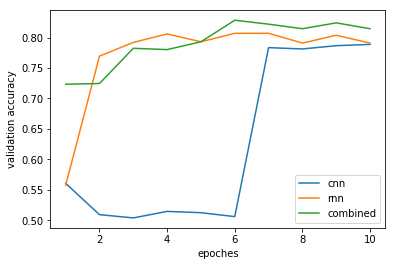

In [21]:
import matplotlib.pyplot as plt
plt.plot(range(1, 11), rec_cnn['val_acc'], label='cnn')
plt.plot(range(1, 11), rec_rnn['val_acc'], label='rnn')
plt.plot(range(1, 11), rec_comb['val_acc'], label='combined')
plt.xlabel('epoches')
plt.ylabel('validation accuracy')
plt.legend()
plt.show()